# sources:

Mixture density
- https://github.com/sagelywizard/pytorch-mdn
- https://towardsdatascience.com/a-hitchhikers-guide-to-mixture-density-networks-76b435826cca
- https://mikedusenberry.com/mixture-density-networks

Kernel density
- https://janvdvegt.github.io/2017/06/07/Kernel-Mixture-Networks.html
- https://arxiv.org/abs/1705.07111

Conclusions:
- the ELU activation function seems more suitable than EXP(x)
- for the kernel density model there is a need to increase the number of gaussians, because k=30 had holes
- the kernel density model converges quicker and has slightly better performance

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

import sys
root = Path().resolve().parents[0]

if str(root) not in sys.path:
    sys.path = [str(root)] + sys.path
    print(f"Path updated with: {root}.")

import time
import math

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.distributions import Categorical

from utils.plot import plot_losses

%load_ext autoreload
%autoreload 2

Path updated with: /Users/giovanniganzinotti/repos/pytorch-azure.


Following cell is from: https://github.com/sagelywizard/pytorch-mdn/blob/master/mdn.py

# DGP

Size of features in training data: (7500, 1)
Size of output in training data: (7500,)
Size of features in test data: (2500, 1)
Size of output in test data: (2500,)


/Users/giovanniganzinotti/.pyenv/versions/3.7.3/envs/pytorch-azure/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


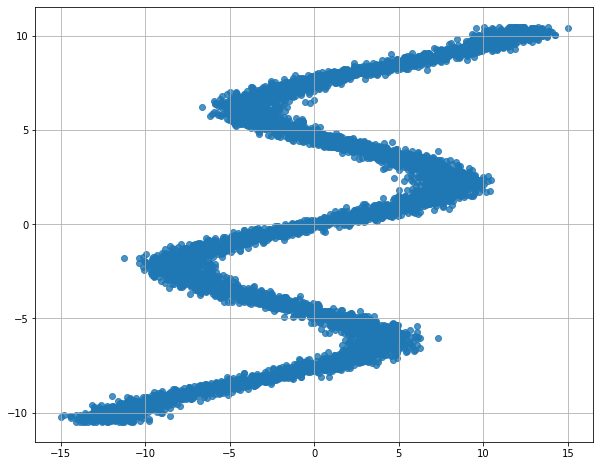

In [2]:
from sklearn.model_selection import train_test_split

def build_toy_dataset(n):
    np.random.seed(41)
    y_data = np.random.uniform(-10.5, 10.5, n)
    r_data = np.random.normal(size=n)  # random noise
    x_data = np.sin(0.75 * y_data) * 7.0 + y_data * 0.5 + r_data * 1.0
    x_data = x_data.reshape((n, 1))
    return train_test_split(x_data, y_data, random_state=42)

n_observations = 10_000  # number of data points
n_features = 1  # number of features

X_train, X_test, y_train, y_test = build_toy_dataset(n_observations)
print("Size of features in training data: {}".format(X_train.shape))
print("Size of output in training data: {}".format(y_train.shape))
print("Size of features in test data: {}".format(X_test.shape))
print("Size of output in test data: {}".format(y_test.shape))

fig, ax = plt.subplots()
fig.set_size_inches(10, 8)
sns.regplot(X_train, y_train, fit_reg=False)
plt.grid()
plt.show()

# Modelling

In [3]:
# constants

device = torch.device('cpu')

input_size = 1
hidden_dense_layers = 50
num_gaussians = 30

batch_size = 512
learning_rate = 0.001
num_epochs = 2_000
n_epochs_stop = 50

model_path = '../models/kernel_density_model.pth'

In [4]:
# utils
def gaussian_probability(sigma, mu, target):
    """Returns the probability of `data` given MoG parameters `sigma` and `mu`.
    
    Arguments:
        sigma (BxGxO): The standard deviation of the Gaussians. B is the batch
            size, G is the number of Gaussians, and O is the number of
            dimensions per Gaussian.
        mu (BxGxO): The means of the Gaussians. B is the batch size, G is the
            number of Gaussians, and O is the number of dimensions per Gaussian.
        data (BxI): A batch of data. B is the batch size and I is the number of
            input dimensions.
    Returns:
        probabilities (BxG): The probability of each point in the probability
            of the distribution in the corresponding sigma/mu index.
    """
    target = target.unsqueeze(1).expand_as(sigma)
    ONEOVERSQRT2PI = 1.0 / math.sqrt(2*math.pi)
    ret = ONEOVERSQRT2PI * torch.exp(-0.5 * ((target - mu) / sigma)**2) / sigma
    return torch.prod(ret, 2)


def mdn_loss(pi, sigma, mu, target):
    """Calculates the error, given the MoG parameters and the target
    The loss is the negative log likelihood of the data given the MoG
    parameters.
    """
    prob = pi * gaussian_probability(sigma, mu, target)
    nll = -torch.log(torch.sum(prob, dim=1))
    return torch.mean(nll)


def sample(pi, sigma, mu):
    """Draw samples from a MoG.
    """
    categorical = Categorical(pi)
    pis = list(categorical.sample().data)
    print(len(pis))
    sample = Variable(sigma.data.new(sigma.size(0), sigma.size(2)).normal_())
    print(sample.shape)
    for i, idx in enumerate(pis):
        sample[i] = sample[i].mul(sigma[i,idx]).add(mu[i,idx])
    return sample


def model_pass(phase: str, model, data_loader):
    possible_values = ("train", "valid")
    if phase not in possible_values:
        raise ValueError(f"phase should be in {possible_values}")
        
    if phase == "train":
        model.train()
    else:
        model.eval()
        
    running_loss = 0
    for idx, (feature, target) in enumerate(data_loader):
        feature = feature.to(device)
        target = target.to(device)
        pi, sigma, mu = model(feature)
        loss = criterion(pi, sigma, mu, target)
        running_loss += loss.item()
        
        if phase == "train":
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
    # not 100% accurate because last incomplete batch has same weight as complete batches
    loss = running_loss / len(data_loader)
    
    return model, loss

def train_model(
    model, 
    criterion, 
    optimizer, 
    train_loader: torch.utils.data.dataloader.DataLoader, 
    valid_loader: torch.utils.data.dataloader.DataLoader, 
    num_epochs: int, 
    n_epochs_stop: int,
    model_save_path: str,
):
    start_time = time.time()

    train_loss_history, valid_loss_history = [], []
    epochs_no_improve = 0
    best_valid_score = np.inf
    
    for epoch in range(1, num_epochs + 1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 30)
        
        # train
        model, train_loss = model_pass("train", model, train_loader)
        train_loss_history.append(train_loss)
        
        # valid
        with torch.no_grad():
            model, valid_loss = model_pass("valid", model, valid_loader)
            valid_loss_history.append(valid_loss)
        
        # save model 
        if valid_loss < best_valid_score:
            epochs_no_improve = 0
            perc_improvement = abs(((best_valid_score - valid_loss) / best_valid_score) * 100)
            print(
                f'valid_loss improved from {best_valid_score:.4f} to {valid_loss:.4f},'
                f' improvement: {perc_improvement:.2f}%'
            )
            best_valid_score = valid_loss

            torch.save(model.state_dict(), model_save_path)
        else:
            epochs_no_improve += 1
            print(f'No improvement in valid_loss for {epochs_no_improve} epochs!')
              
        print(
            f'train_loss : {train_loss}\n'
            f'valid_loss: {valid_loss}\n'
            f'{"-" * 30}' 
        )
        
        if epoch > 5 and epochs_no_improve == n_epochs_stop:
            print(f'Early stopping triggered after {epoch} epochs!')
            break
    
    print(f"Training lasted: {time.time() - start_time:.2f} seconds")
    
    return model, train_loss_history, valid_loss_history, best_valid_score

def sample_preds(pi, sigma, mu, samples=10):
    # rather than sample the single conditional mode at each
    # point, we could sample many points from the GMM produced
    # by the model for each point, yielding a dense set of
    # predictions
    N, K = pi.shape
    _, KT = mu.shape
    T = int(KT / K)
    out = Variable(torch.zeros(N, samples, T))  # s samples per example
    for i in range(N):
        for j in range(samples):
            # pi must sum to 1, thus we can sample from a uniform
            # distribution, then transform that to select the component
            u = np.random.uniform()  # sample from [0, 1)
            # split [0, 1] into k segments: [0, pi[0]), [pi[0], pi[1]), ..., [pi[K-1], pi[K])
            # then determine the segment `u` that falls into and sample from that component
            prob_sum = 0
            for k in range(K):
                prob_sum += pi.data[i, k]
                if u < prob_sum:
                    # sample from the kth component
                    for t in range(T):
                        sample = np.random.normal(mu.data[i, k*T+t], sigma.data[i, k])
                        out[i, j, t] = sample
                    break
    return out

# data setup

In [5]:
def return_dataset_and_loader(x, y, batch_size: int = 32, shuffle: bool = True):
    dataset = torch.utils.data.TensorDataset(
        torch.from_numpy(x.reshape(-1, 1)).float(),
        torch.from_numpy(y.reshape(-1, 1)).float(),
    )

    loader = torch.utils.data.DataLoader(
        dataset=dataset, 
        batch_size=batch_size, 
        shuffle=shuffle,
    )
    
    return dataset, loader
                         
train_dataset, train_loader = return_dataset_and_loader(X_train, y_train, batch_size=batch_size, shuffle=True)
test_dataset, test_loader = return_dataset_and_loader(X_test, y_test, batch_size=X_test.shape[0], shuffle=False)
                         
for seq, target in test_loader:
    print(seq.shape, target.shape)
    print(seq.dtype, target.dtype)

torch.Size([2500, 1]) torch.Size([2500, 1])
torch.float32 torch.float32


# mixture_density_model

In [6]:
class MDN(nn.Module):
    """A mixture density network layer
    The input maps to the parameters of a MoG probability distribution, where
    each Gaussian has O dimensions and diagonal covariance.
    Arguments:
        in_features (int): the number of dimensions in the input that enters the MDN output layer
        out_features (int): the number of dimensions in the output per gaussian
        num_gaussians (int): the number of Gaussians per output dimensions
    Input:
        minibatch (BxD): B is the batch size and D is the number of input
            dimensions.
    Output:
        (pi, sigma, mu) (BxG, BxGxO, BxGxO): B is the batch size, G is the
            number of Gaussians, and O is the number of dimensions for each
            Gaussian. Pi is a multinomial distribution of the Gaussians. Sigma
            is the standard deviation of each Gaussian. Mu is the mean of each
            Gaussian.
    """
    def __init__(self, in_features, out_features, num_gaussians):
        super(MDN, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.num_gaussians = num_gaussians
        self.pi = nn.Sequential(
            nn.Linear(in_features, num_gaussians),
            nn.Softmax(dim=1)
        )
        self.sigma = nn.Linear(in_features, out_features*num_gaussians)
        self.mu = nn.Linear(in_features, out_features*num_gaussians)

    def forward(self, minibatch):
        pi = self.pi(minibatch)
        sigma = torch.exp(self.sigma(minibatch))
        sigma = sigma.view(-1, self.num_gaussians, self.out_features)
        mu = self.mu(minibatch)
        mu = mu.view(-1, self.num_gaussians, self.out_features)
        return pi, sigma, mu


model = nn.Sequential(
    nn.Linear(input_size, hidden_dense_layers),
    nn.Tanh(),
    nn.Linear(hidden_dense_layers, hidden_dense_layers),
    nn.Tanh(),
    MDN(hidden_dense_layers, 1, num_gaussians),
)
criterion = mdn_loss
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [7]:
print(model)

Sequential(
  (0): Linear(in_features=1, out_features=50, bias=True)
  (1): Tanh()
  (2): Linear(in_features=50, out_features=50, bias=True)
  (3): Tanh()
  (4): MDN(
    (pi): Sequential(
      (0): Linear(in_features=50, out_features=30, bias=True)
      (1): Softmax(dim=1)
    )
    (sigma): Linear(in_features=50, out_features=30, bias=True)
    (mu): Linear(in_features=50, out_features=30, bias=True)
  )
)


In [8]:
model, train_loss_history, valid_loss_history, best_valid_score = train_model(
    model,
    criterion,
    optimizer,
    train_loader,
    test_loader,
    num_epochs,
    n_epochs_stop,
    model_path,
)

Epoch 1/2000
------------------------------
valid_loss improved from inf to 4.7920, improvement: nan%
train_loss : 6.679941463470459
valid_loss: 4.792023181915283
------------------------------
Epoch 2/2000
------------------------------
valid_loss improved from 4.7920 to 3.7926, improvement: 20.86%
train_loss : 4.216555293401083
valid_loss: 3.7925772666931152
------------------------------
Epoch 3/2000
------------------------------
valid_loss improved from 3.7926 to 3.3806, improvement: 10.86%
train_loss : 3.5216337045033774
valid_loss: 3.3806159496307373
------------------------------
Epoch 4/2000
------------------------------
valid_loss improved from 3.3806 to 3.2790, improvement: 3.01%
train_loss : 3.2975964069366457
valid_loss: 3.2789528369903564
------------------------------
Epoch 5/2000
------------------------------
valid_loss improved from 3.2790 to 3.2228, improvement: 1.71%
train_loss : 3.2264087518056233
valid_loss: 3.2227678298950195
------------------------------
Epoch

valid_loss improved from 1.6576 to 1.6328, improvement: 1.50%
train_loss : 1.617001485824585
valid_loss: 1.6328132152557373
------------------------------
Epoch 43/2000
------------------------------
valid_loss improved from 1.6328 to 1.6298, improvement: 0.19%
train_loss : 1.6101243893305461
valid_loss: 1.629758358001709
------------------------------
Epoch 44/2000
------------------------------
valid_loss improved from 1.6298 to 1.6259, improvement: 0.24%
train_loss : 1.605751903851827
valid_loss: 1.6258912086486816
------------------------------
Epoch 45/2000
------------------------------
valid_loss improved from 1.6259 to 1.6248, improvement: 0.06%
train_loss : 1.5971914927164714
valid_loss: 1.6248385906219482
------------------------------
Epoch 46/2000
------------------------------
valid_loss improved from 1.6248 to 1.6137, improvement: 0.68%
train_loss : 1.5905889431635538
valid_loss: 1.6137460470199585
------------------------------
Epoch 47/2000
-----------------------------

valid_loss improved from 1.5004 to 1.4972, improvement: 0.22%
train_loss : 1.4751485586166382
valid_loss: 1.4971576929092407
------------------------------
Epoch 86/2000
------------------------------
No improvement in valid_loss for 1 epochs!
train_loss : 1.468695092201233
valid_loss: 1.5003740787506104
------------------------------
Epoch 87/2000
------------------------------
valid_loss improved from 1.4972 to 1.4969, improvement: 0.01%
train_loss : 1.4734521865844727
valid_loss: 1.4969396591186523
------------------------------
Epoch 88/2000
------------------------------
No improvement in valid_loss for 1 epochs!
train_loss : 1.4696725924809775
valid_loss: 1.5026501417160034
------------------------------
Epoch 89/2000
------------------------------
valid_loss improved from 1.4969 to 1.4945, improvement: 0.16%
train_loss : 1.4746708154678345
valid_loss: 1.494515061378479
------------------------------
Epoch 90/2000
------------------------------
valid_loss improved from 1.4945 to 

No improvement in valid_loss for 3 epochs!
train_loss : 1.4448196252187093
valid_loss: 1.4680687189102173
------------------------------
Epoch 130/2000
------------------------------
valid_loss improved from 1.4605 to 1.4596, improvement: 0.06%
train_loss : 1.442113979657491
valid_loss: 1.459600567817688
------------------------------
Epoch 131/2000
------------------------------
valid_loss improved from 1.4596 to 1.4576, improvement: 0.14%
train_loss : 1.4399743874867756
valid_loss: 1.4576274156570435
------------------------------
Epoch 132/2000
------------------------------
No improvement in valid_loss for 1 epochs!
train_loss : 1.4423382759094239
valid_loss: 1.4610451459884644
------------------------------
Epoch 133/2000
------------------------------
No improvement in valid_loss for 2 epochs!
train_loss : 1.4395408868789672
valid_loss: 1.4590550661087036
------------------------------
Epoch 134/2000
------------------------------
No improvement in valid_loss for 3 epochs!
train_

No improvement in valid_loss for 3 epochs!
train_loss : 1.4250660339991252
valid_loss: 1.4455050230026245
------------------------------
Epoch 174/2000
------------------------------
No improvement in valid_loss for 4 epochs!
train_loss : 1.4296785434087118
valid_loss: 1.4477442502975464
------------------------------
Epoch 175/2000
------------------------------
No improvement in valid_loss for 5 epochs!
train_loss : 1.426478592554728
valid_loss: 1.444272756576538
------------------------------
Epoch 176/2000
------------------------------
No improvement in valid_loss for 6 epochs!
train_loss : 1.4273454427719117
valid_loss: 1.446928858757019
------------------------------
Epoch 177/2000
------------------------------
valid_loss improved from 1.4439 to 1.4415, improvement: 0.17%
train_loss : 1.4275195598602295
valid_loss: 1.4414854049682617
------------------------------
Epoch 178/2000
------------------------------
No improvement in valid_loss for 1 epochs!
train_loss : 1.42744991779

No improvement in valid_loss for 7 epochs!
train_loss : 1.4215830882390341
valid_loss: 1.4321913719177246
------------------------------
Epoch 219/2000
------------------------------
No improvement in valid_loss for 8 epochs!
train_loss : 1.4205322424570719
valid_loss: 1.4406870603561401
------------------------------
Epoch 220/2000
------------------------------
No improvement in valid_loss for 9 epochs!
train_loss : 1.4200990200042725
valid_loss: 1.4339817762374878
------------------------------
Epoch 221/2000
------------------------------
No improvement in valid_loss for 10 epochs!
train_loss : 1.4147651354471842
valid_loss: 1.4455790519714355
------------------------------
Epoch 222/2000
------------------------------
No improvement in valid_loss for 11 epochs!
train_loss : 1.4234643459320069
valid_loss: 1.4317302703857422
------------------------------
Epoch 223/2000
------------------------------
No improvement in valid_loss for 12 epochs!
train_loss : 1.4170886357625325
valid_l

No improvement in valid_loss for 10 epochs!
train_loss : 1.4097156206766763
valid_loss: 1.431862235069275
------------------------------
Epoch 264/2000
------------------------------
No improvement in valid_loss for 11 epochs!
train_loss : 1.4115620136260987
valid_loss: 1.4279730319976807
------------------------------
Epoch 265/2000
------------------------------
No improvement in valid_loss for 12 epochs!
train_loss : 1.4129034439722696
valid_loss: 1.4315646886825562
------------------------------
Epoch 266/2000
------------------------------
valid_loss improved from 1.4267 to 1.4248, improvement: 0.13%
train_loss : 1.4105072418848674
valid_loss: 1.4248075485229492
------------------------------
Epoch 267/2000
------------------------------
No improvement in valid_loss for 1 epochs!
train_loss : 1.413625963528951
valid_loss: 1.434470772743225
------------------------------
Epoch 268/2000
------------------------------
valid_loss improved from 1.4248 to 1.4244, improvement: 0.03%
trai

No improvement in valid_loss for 14 epochs!
train_loss : 1.4088897466659547
valid_loss: 1.428822636604309
------------------------------
Epoch 309/2000
------------------------------
No improvement in valid_loss for 15 epochs!
train_loss : 1.4086419661839804
valid_loss: 1.4325894117355347
------------------------------
Epoch 310/2000
------------------------------
No improvement in valid_loss for 16 epochs!
train_loss : 1.409567618370056
valid_loss: 1.4295395612716675
------------------------------
Epoch 311/2000
------------------------------
No improvement in valid_loss for 17 epochs!
train_loss : 1.409480357170105
valid_loss: 1.4194588661193848
------------------------------
Epoch 312/2000
------------------------------
No improvement in valid_loss for 18 epochs!
train_loss : 1.4102110703786215
valid_loss: 1.4264805316925049
------------------------------
Epoch 313/2000
------------------------------
No improvement in valid_loss for 19 epochs!
train_loss : 1.4088234980901082
valid_l

No improvement in valid_loss for 25 epochs!
train_loss : 1.4049590269724528
valid_loss: 1.4175701141357422
------------------------------
Epoch 354/2000
------------------------------
No improvement in valid_loss for 26 epochs!
train_loss : 1.405661686261495
valid_loss: 1.4227771759033203
------------------------------
Epoch 355/2000
------------------------------
No improvement in valid_loss for 27 epochs!
train_loss : 1.4047234296798705
valid_loss: 1.4204719066619873
------------------------------
Epoch 356/2000
------------------------------
No improvement in valid_loss for 28 epochs!
train_loss : 1.4081535498301188
valid_loss: 1.4174551963806152
------------------------------
Epoch 357/2000
------------------------------
No improvement in valid_loss for 29 epochs!
train_loss : 1.4046677112579347
valid_loss: 1.420152187347412
------------------------------
Epoch 358/2000
------------------------------
No improvement in valid_loss for 30 epochs!
train_loss : 1.4035170237223307
valid_

No improvement in valid_loss for 21 epochs!
train_loss : 1.4071176211039225
valid_loss: 1.4232882261276245
------------------------------
Epoch 399/2000
------------------------------
No improvement in valid_loss for 22 epochs!
train_loss : 1.4017744779586792
valid_loss: 1.4222424030303955
------------------------------
Epoch 400/2000
------------------------------
No improvement in valid_loss for 23 epochs!
train_loss : 1.4071811278661093
valid_loss: 1.4196484088897705
------------------------------
Epoch 401/2000
------------------------------
No improvement in valid_loss for 24 epochs!
train_loss : 1.4062589406967163
valid_loss: 1.4215919971466064
------------------------------
Epoch 402/2000
------------------------------
No improvement in valid_loss for 25 epochs!
train_loss : 1.4036193052927652
valid_loss: 1.4244037866592407
------------------------------
Epoch 403/2000
------------------------------
No improvement in valid_loss for 26 epochs!
train_loss : 1.4094218015670776
vali

No improvement in valid_loss for 22 epochs!
train_loss : 1.4056531190872192
valid_loss: 1.4157469272613525
------------------------------
Epoch 444/2000
------------------------------
No improvement in valid_loss for 23 epochs!
train_loss : 1.4001405636469524
valid_loss: 1.4179174900054932
------------------------------
Epoch 445/2000
------------------------------
No improvement in valid_loss for 24 epochs!
train_loss : 1.3997536579767862
valid_loss: 1.4163044691085815
------------------------------
Epoch 446/2000
------------------------------
No improvement in valid_loss for 25 epochs!
train_loss : 1.3994617621103922
valid_loss: 1.4176210165023804
------------------------------
Epoch 447/2000
------------------------------
No improvement in valid_loss for 26 epochs!
train_loss : 1.4060124317804972
valid_loss: 1.415627121925354
------------------------------
Epoch 448/2000
------------------------------
No improvement in valid_loss for 27 epochs!
train_loss : 1.4007260163625082
valid

No improvement in valid_loss for 30 epochs!
train_loss : 1.4082338412602742
valid_loss: 1.4200392961502075
------------------------------
Epoch 489/2000
------------------------------
No improvement in valid_loss for 31 epochs!
train_loss : 1.399851131439209
valid_loss: 1.4202349185943604
------------------------------
Epoch 490/2000
------------------------------
No improvement in valid_loss for 32 epochs!
train_loss : 1.4001421689987184
valid_loss: 1.4213886260986328
------------------------------
Epoch 491/2000
------------------------------
No improvement in valid_loss for 33 epochs!
train_loss : 1.4002545992533366
valid_loss: 1.4196617603302002
------------------------------
Epoch 492/2000
------------------------------
No improvement in valid_loss for 34 epochs!
train_loss : 1.4007604598999024
valid_loss: 1.41587233543396
------------------------------
Epoch 493/2000
------------------------------
No improvement in valid_loss for 35 epochs!
train_loss : 1.398401959737142
valid_lo

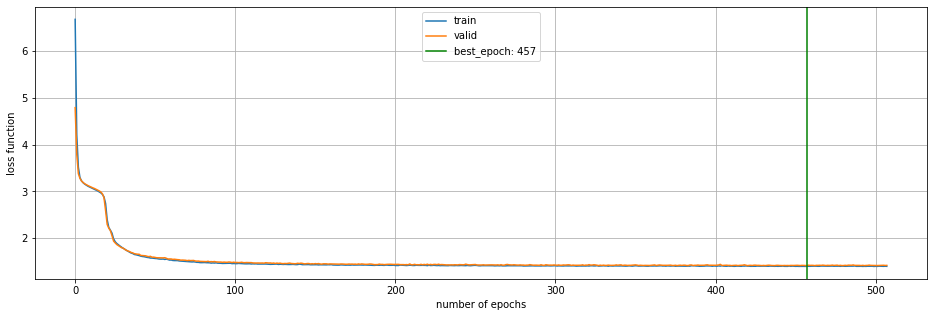

In [9]:
plot_losses(train_loss_history, valid_loss_history, best_valid_score, burn_in=0)

torch.Size([2500, 30]) torch.Size([2500, 30, 1]) torch.Size([2500, 30, 1])


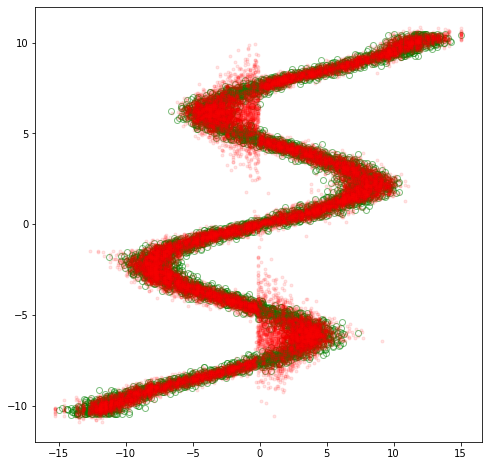

In [10]:
for features, targets in test_loader:
    pi, sigma, mu = model(features)
    
print(pi.shape, sigma.shape, mu.shape)

preds = sample_preds(
    torch.squeeze(pi), 
    torch.squeeze(sigma), 
    torch.squeeze(mu), 
    samples=10,
)

fig = plt.figure(figsize=(8,8))
plt.plot(X_train, y_train, 'go', alpha=0.5, markerfacecolor='none')
for i in range(preds.shape[1]):
    plt.plot(X_test, preds.data.numpy()[:, i].reshape(-1, 1), 'r.', alpha=0.1)
plt.show()

# elu vs exp comparison

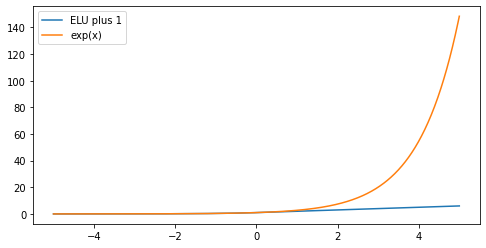

In [11]:
x_axis = np.linspace(-5, 5, num=1_000)

x_axis_tensor = torch.from_numpy(x_axis.reshape(-1, 1)).float()
elu_layer = torch.nn.ELU(alpha=1.0)
elu_series = elu_layer.forward(x_axis_tensor).detach().numpy().flatten() + 1

plt.figure(figsize=(8, 4))
plt.plot(x_axis, elu_series, label="ELU plus 1")
plt.plot(x_axis, np.exp(x_axis), label="exp(x)")
plt.legend()
plt.show()

In [12]:
base = torch.normal(0, 5, size=(5, 4))
print(base)

elu_layer.forward(base) + 1

tensor([[ -6.3446, -11.5308,   7.5810,   2.2812],
        [ -2.3398,  -9.6009,  14.4864,  11.7169],
        [ -2.1190,   5.8846,  -7.5600,   2.5752],
        [ -5.0394,   2.2258,  -3.3459,  -0.8038],
        [ -5.6896,   6.1992,   6.0798,  -1.9022]])


tensor([[1.7562e-03, 9.8348e-06, 8.5810e+00, 3.2812e+00],
        [9.6350e-02, 6.7651e-05, 1.5486e+01, 1.2717e+01],
        [1.2015e-01, 6.8846e+00, 5.2083e-04, 3.5752e+00],
        [6.4778e-03, 3.2258e+00, 3.5228e-02, 4.4764e-01],
        [3.3810e-03, 7.1992e+00, 7.0798e+00, 1.4924e-01]])

Conclusion: elu seems to make more sense, because it is a lot less sensitive. Lets adjust the model.

In [13]:
class MixutreDensityNetwork(nn.Module):
    """A mixture density network layer
    The input maps to the parameters of a MoG probability distribution, where
    each Gaussian has O dimensions and diagonal covariance.
    Arguments:
        in_features (int): the number of dimensions in the input that enters the MDN output layer
        out_features (int): the number of dimensions in the output per gaussian
        num_gaussians (int): the number of Gaussians per output dimensions
    Input:
        minibatch (BxD): B is the batch size and D is the number of input
            dimensions.
    Output:
        (pi, sigma, mu) (BxG, BxGxO, BxGxO): B is the batch size, G is the
            number of Gaussians, and O is the number of dimensions for each
            Gaussian. Pi is a multinomial distribution of the Gaussians. Sigma
            is the standard deviation of each Gaussian. Mu is the mean of each
            Gaussian.
    """
    def __init__(self, in_features, out_features, num_gaussians):
        super(MixutreDensityNetwork, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.num_gaussians = num_gaussians
        
        self.pi = nn.Sequential(
            nn.Linear(in_features, num_gaussians),
            nn.Softmax(dim=1)
        )
        self.sigma = nn.Sequential(
            nn.Linear(in_features, out_features*num_gaussians),
            nn.ELU(alpha=1.0)
        )
        self.mu = nn.Linear(in_features, out_features*num_gaussians)

    def forward(self, minibatch):
        pi = self.pi(minibatch)
        
        sigma = self.sigma(minibatch)
        sigma = sigma + 1
        sigma = sigma.view(-1, self.num_gaussians, self.out_features)
        
        mu = self.mu(minibatch)
        mu = mu.view(-1, self.num_gaussians, self.out_features)
        return pi, sigma, mu


mixture_density_model = nn.Sequential(
    nn.Linear(input_size, hidden_dense_layers),
    nn.Tanh(),
    nn.Linear(hidden_dense_layers, hidden_dense_layers),
    nn.Tanh(),
    MixutreDensityNetwork(hidden_dense_layers, 1, num_gaussians),
)

criterion = mdn_loss
optimizer = optim.Adam(mixture_density_model.parameters(), lr=learning_rate)

print(mixture_density_model)

Sequential(
  (0): Linear(in_features=1, out_features=50, bias=True)
  (1): Tanh()
  (2): Linear(in_features=50, out_features=50, bias=True)
  (3): Tanh()
  (4): MixutreDensityNetwork(
    (pi): Sequential(
      (0): Linear(in_features=50, out_features=30, bias=True)
      (1): Softmax(dim=1)
    )
    (sigma): Sequential(
      (0): Linear(in_features=50, out_features=30, bias=True)
      (1): ELU(alpha=1.0)
    )
    (mu): Linear(in_features=50, out_features=30, bias=True)
  )
)


In [14]:
mixture_density_model, train_loss_history, valid_loss_history, best_valid_score = train_model(
    mixture_density_model,
    criterion,
    optimizer,
    train_loader,
    test_loader,
    num_epochs,
    n_epochs_stop,
    model_path,
)

Epoch 1/2000
------------------------------
valid_loss improved from inf to 6.5600, improvement: nan%
train_loss : 8.875682353973389
valid_loss: 6.559990406036377
------------------------------
Epoch 2/2000
------------------------------
valid_loss improved from 6.5600 to 4.9619, improvement: 24.36%
train_loss : 5.670859622955322
valid_loss: 4.9619340896606445
------------------------------
Epoch 3/2000
------------------------------
valid_loss improved from 4.9619 to 4.0550, improvement: 18.28%
train_loss : 4.4492844899495445
valid_loss: 4.055016994476318
------------------------------
Epoch 4/2000
------------------------------
valid_loss improved from 4.0550 to 3.5639, improvement: 12.11%
train_loss : 3.747253974278768
valid_loss: 3.5638651847839355
------------------------------
Epoch 5/2000
------------------------------
valid_loss improved from 3.5639 to 3.3482, improvement: 6.05%
train_loss : 3.395147212346395
valid_loss: 3.3482062816619873
------------------------------
Epoch 6

valid_loss improved from 2.1411 to 2.1269, improvement: 0.66%
train_loss : 2.107812444368998
valid_loss: 2.126934766769409
------------------------------
Epoch 43/2000
------------------------------
valid_loss improved from 2.1269 to 2.1214, improvement: 0.26%
train_loss : 2.100110387802124
valid_loss: 2.1213600635528564
------------------------------
Epoch 44/2000
------------------------------
valid_loss improved from 2.1214 to 2.1112, improvement: 0.48%
train_loss : 2.0928855895996095
valid_loss: 2.111222267150879
------------------------------
Epoch 45/2000
------------------------------
valid_loss improved from 2.1112 to 2.1082, improvement: 0.14%
train_loss : 2.0819650014241535
valid_loss: 2.1082003116607666
------------------------------
Epoch 46/2000
------------------------------
valid_loss improved from 2.1082 to 2.0903, improvement: 0.85%
train_loss : 2.0774276574452717
valid_loss: 2.0902507305145264
------------------------------
Epoch 47/2000
------------------------------

valid_loss improved from 1.6424 to 1.6337, improvement: 0.53%
train_loss : 1.6483387231826783
valid_loss: 1.6336721181869507
------------------------------
Epoch 85/2000
------------------------------
No improvement in valid_loss for 1 epochs!
train_loss : 1.6391271114349366
valid_loss: 1.644329309463501
------------------------------
Epoch 86/2000
------------------------------
valid_loss improved from 1.6337 to 1.6261, improvement: 0.46%
train_loss : 1.6337721586227416
valid_loss: 1.626112461090088
------------------------------
Epoch 87/2000
------------------------------
No improvement in valid_loss for 1 epochs!
train_loss : 1.6315099000930786
valid_loss: 1.6275473833084106
------------------------------
Epoch 88/2000
------------------------------
valid_loss improved from 1.6261 to 1.6139, improvement: 0.75%
train_loss : 1.622909911473592
valid_loss: 1.613944411277771
------------------------------
Epoch 89/2000
------------------------------
valid_loss improved from 1.6139 to 1.

valid_loss improved from 1.4826 to 1.4792, improvement: 0.23%
train_loss : 1.4676305611928304
valid_loss: 1.4791679382324219
------------------------------
Epoch 127/2000
------------------------------
No improvement in valid_loss for 1 epochs!
train_loss : 1.469348406791687
valid_loss: 1.4832909107208252
------------------------------
Epoch 128/2000
------------------------------
valid_loss improved from 1.4792 to 1.4785, improvement: 0.04%
train_loss : 1.464887054761251
valid_loss: 1.4785126447677612
------------------------------
Epoch 129/2000
------------------------------
No improvement in valid_loss for 1 epochs!
train_loss : 1.4647473335266112
valid_loss: 1.478891372680664
------------------------------
Epoch 130/2000
------------------------------
valid_loss improved from 1.4785 to 1.4778, improvement: 0.05%
train_loss : 1.4630271196365356
valid_loss: 1.4778369665145874
------------------------------
Epoch 131/2000
------------------------------
valid_loss improved from 1.4778

valid_loss improved from 1.4511 to 1.4495, improvement: 0.11%
train_loss : 1.4283733765284221
valid_loss: 1.4495384693145752
------------------------------
Epoch 171/2000
------------------------------
valid_loss improved from 1.4495 to 1.4469, improvement: 0.18%
train_loss : 1.4284255107243855
valid_loss: 1.4468640089035034
------------------------------
Epoch 172/2000
------------------------------
No improvement in valid_loss for 1 epochs!
train_loss : 1.4298954804738362
valid_loss: 1.4489835500717163
------------------------------
Epoch 173/2000
------------------------------
No improvement in valid_loss for 2 epochs!
train_loss : 1.426027766863505
valid_loss: 1.455336093902588
------------------------------
Epoch 174/2000
------------------------------
No improvement in valid_loss for 3 epochs!
train_loss : 1.4272399187088012
valid_loss: 1.4540480375289917
------------------------------
Epoch 175/2000
------------------------------
No improvement in valid_loss for 4 epochs!
train_

No improvement in valid_loss for 4 epochs!
train_loss : 1.4121477524439494
valid_loss: 1.4344596862792969
------------------------------
Epoch 215/2000
------------------------------
No improvement in valid_loss for 5 epochs!
train_loss : 1.412829875946045
valid_loss: 1.4356640577316284
------------------------------
Epoch 216/2000
------------------------------
No improvement in valid_loss for 6 epochs!
train_loss : 1.4153845230738322
valid_loss: 1.4363025426864624
------------------------------
Epoch 217/2000
------------------------------
No improvement in valid_loss for 7 epochs!
train_loss : 1.4158273061116537
valid_loss: 1.4355082511901855
------------------------------
Epoch 218/2000
------------------------------
valid_loss improved from 1.4318 to 1.4307, improvement: 0.08%
train_loss : 1.4156971534093221
valid_loss: 1.4307153224945068
------------------------------
Epoch 219/2000
------------------------------
No improvement in valid_loss for 1 epochs!
train_loss : 1.415176757

valid_loss improved from 1.4246 to 1.4233, improvement: 0.09%
train_loss : 1.4057957092920939
valid_loss: 1.4233473539352417
------------------------------
Epoch 260/2000
------------------------------
No improvement in valid_loss for 1 epochs!
train_loss : 1.4068440834681193
valid_loss: 1.4274975061416626
------------------------------
Epoch 261/2000
------------------------------
No improvement in valid_loss for 2 epochs!
train_loss : 1.4071925004323325
valid_loss: 1.4303337335586548
------------------------------
Epoch 262/2000
------------------------------
No improvement in valid_loss for 3 epochs!
train_loss : 1.402254343032837
valid_loss: 1.43097984790802
------------------------------
Epoch 263/2000
------------------------------
No improvement in valid_loss for 4 epochs!
train_loss : 1.4057677268981934
valid_loss: 1.4237613677978516
------------------------------
Epoch 264/2000
------------------------------
No improvement in valid_loss for 5 epochs!
train_loss : 1.40654140313

No improvement in valid_loss for 39 epochs!
train_loss : 1.403510610262553
valid_loss: 1.4242351055145264
------------------------------
Epoch 305/2000
------------------------------
valid_loss improved from 1.4210 to 1.4200, improvement: 0.07%
train_loss : 1.4005193392435709
valid_loss: 1.4200053215026855
------------------------------
Epoch 306/2000
------------------------------
No improvement in valid_loss for 1 epochs!
train_loss : 1.4028210560480754
valid_loss: 1.427681803703308
------------------------------
Epoch 307/2000
------------------------------
No improvement in valid_loss for 2 epochs!
train_loss : 1.3997432708740234
valid_loss: 1.4262889623641968
------------------------------
Epoch 308/2000
------------------------------
valid_loss improved from 1.4200 to 1.4166, improvement: 0.24%
train_loss : 1.3984865427017212
valid_loss: 1.4165596961975098
------------------------------
Epoch 309/2000
------------------------------
No improvement in valid_loss for 1 epochs!
train

No improvement in valid_loss for 41 epochs!
train_loss : 1.4002695083618164
valid_loss: 1.422884225845337
------------------------------
Epoch 350/2000
------------------------------
No improvement in valid_loss for 42 epochs!
train_loss : 1.4007439772288004
valid_loss: 1.4224485158920288
------------------------------
Epoch 351/2000
------------------------------
No improvement in valid_loss for 43 epochs!
train_loss : 1.4001022577285767
valid_loss: 1.4292399883270264
------------------------------
Epoch 352/2000
------------------------------
No improvement in valid_loss for 44 epochs!
train_loss : 1.3988196134567261
valid_loss: 1.4268304109573364
------------------------------
Epoch 353/2000
------------------------------
No improvement in valid_loss for 45 epochs!
train_loss : 1.39596639474233
valid_loss: 1.4253532886505127
------------------------------
Epoch 354/2000
------------------------------
No improvement in valid_loss for 46 epochs!
train_loss : 1.4009502490361532
valid_l

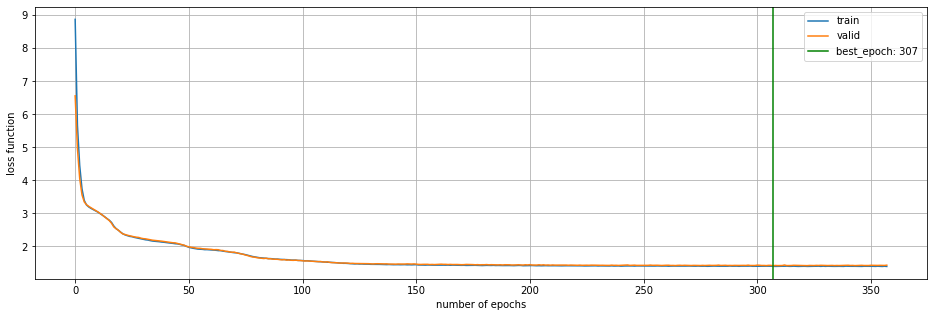

In [15]:
plot_losses(train_loss_history, valid_loss_history, best_valid_score, burn_in=0)

torch.Size([2500, 30]) torch.Size([2500, 30, 1]) torch.Size([2500, 30, 1])


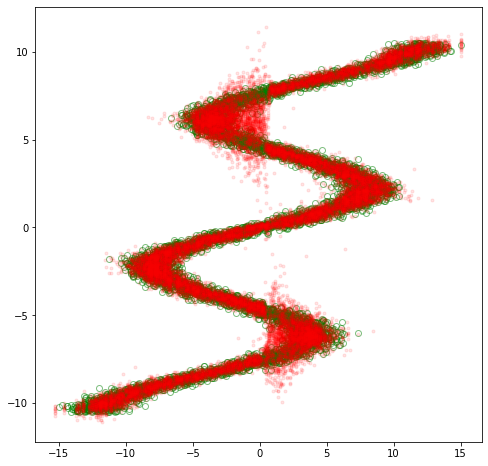

In [16]:
for features, targets in test_loader:
    pi, sigma, mu = mixture_density_model(features)
    
print(pi.shape, sigma.shape, mu.shape)

preds = sample_preds(
    torch.squeeze(pi), 
    torch.squeeze(sigma), 
    torch.squeeze(mu), 
    samples=10,
)

fig = plt.figure(figsize=(8,8))
plt.plot(X_train, y_train, 'go', alpha=0.5, markerfacecolor='none')
for i in range(preds.shape[1]):
    plt.plot(X_test, preds.data.numpy()[:, i].reshape(-1, 1), 'r.', alpha=0.1)
plt.show()

# additional plots
(garbage)

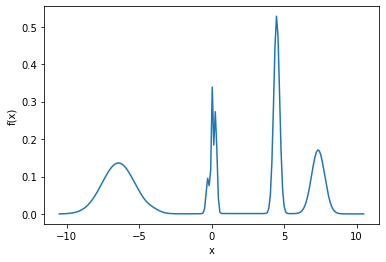

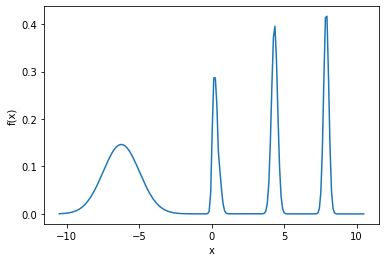

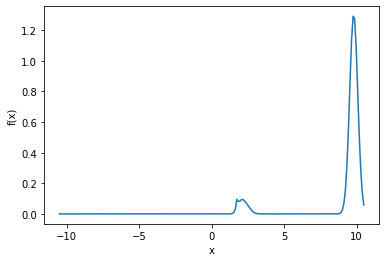

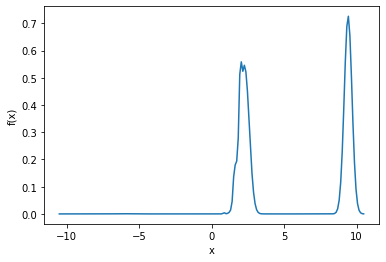

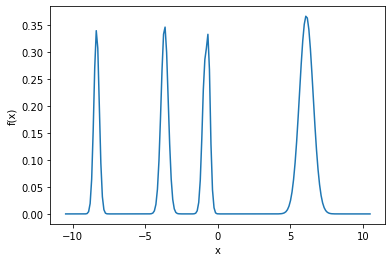

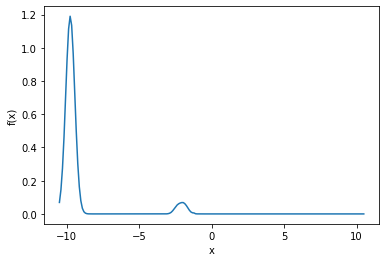

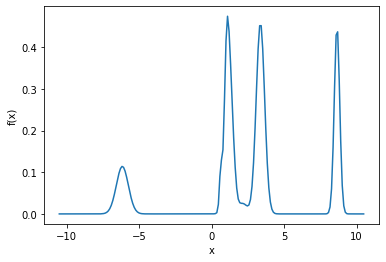

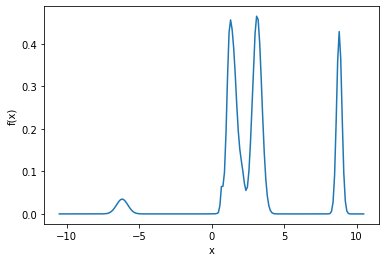

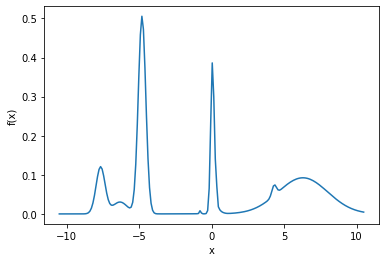

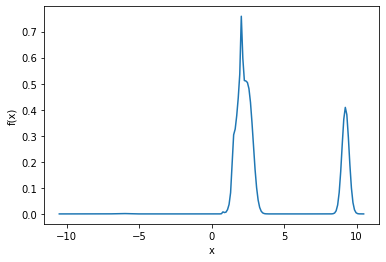

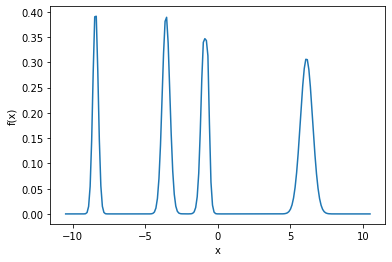

In [17]:
import scipy.stats as ss


def plot_theoretical_mixture_density(
    mu: np.ndarray, 
    sigma: np.ndarray, 
    weights: np.ndarray, 
    y: np.ndarray,
    steps: int = 200,
):
    xs = np.linspace(y.min(), y.max(), steps)

    ys = np.zeros_like(xs)
    for l, s, w in zip(mu, sigma, weights):
        ys += ss.norm.pdf(xs, loc=l, scale=s) * w

    plt.plot(xs, ys)
    plt.xlabel("x")
    plt.ylabel("f(x)")
    plt.show()
    
    
for i in range(len(X_test)):
    plot_theoretical_mixture_density(
        mu[i].detach().numpy().flatten(),
        sigma[i].detach().numpy().flatten(),
        pi[i].detach().numpy().flatten(),
        y_test,
    )

    if i == 10:
        break

# kernel density

In [18]:
num_gaussians = 50

In [19]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=num_gaussians)
model.fit(y_train.reshape(-1, 1))
cluster_centers = model.cluster_centers_

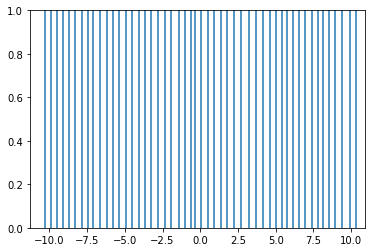

In [20]:
plt.figure()
for center in cluster_centers:
    plt.axvline(x=center)
plt.show()

In [21]:
class KernelDensityNetwork(nn.Module):
    def __init__(self, in_features, out_features, num_gaussians):
        super(KernelDensityNetwork, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.num_gaussians = num_gaussians
        
        self.pi = nn.Sequential(
            nn.Linear(in_features, num_gaussians),
            nn.Softmax(dim=1)
        )
        self.sigma = nn.Sequential(
            nn.Linear(in_features, out_features*num_gaussians),
            nn.ELU(alpha=1.0)
        )

    def forward(self, minibatch):
        pi = self.pi(minibatch)
        
        sigma = self.sigma(minibatch)
        sigma = sigma + 1
        sigma = sigma.view(-1, self.num_gaussians, self.out_features)
        
        return pi, sigma

kernel_density_model = nn.Sequential(
    nn.Linear(input_size, hidden_dense_layers),
    nn.Tanh(),
    nn.Linear(hidden_dense_layers, hidden_dense_layers),
    nn.Tanh(),
    KernelDensityNetwork(hidden_dense_layers, 1, num_gaussians),
)

criterion = mdn_loss
optimizer = optim.Adam(kernel_density_model.parameters(), lr=learning_rate)

print(mixture_density_model)

Sequential(
  (0): Linear(in_features=1, out_features=50, bias=True)
  (1): Tanh()
  (2): Linear(in_features=50, out_features=50, bias=True)
  (3): Tanh()
  (4): MixutreDensityNetwork(
    (pi): Sequential(
      (0): Linear(in_features=50, out_features=30, bias=True)
      (1): Softmax(dim=1)
    )
    (sigma): Sequential(
      (0): Linear(in_features=50, out_features=30, bias=True)
      (1): ELU(alpha=1.0)
    )
    (mu): Linear(in_features=50, out_features=30, bias=True)
  )
)


In [22]:
def model_pass_kernel(
    phase: str, model, data_loader, cluster_centers: np.ndarray,
):
    possible_values = ("train", "valid")
    if phase not in possible_values:
        raise ValueError(f"phase should be in {possible_values}")
        
    if phase == "train":
        model.train()
    else:
        model.eval()
        
    running_loss = 0
    for idx, (feature, target) in enumerate(data_loader):
        feature = feature.to(device)
        target = target.to(device)
        pi, sigma = model(feature)
        
        mu = torch.from_numpy(cluster_centers).unsqueeze(dim=0)
        mu = torch.cat(feature.shape[0]*[mu])

        loss = criterion(pi, sigma, mu, target)
        running_loss += loss.item()
        
        if phase == "train":
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
    # not 100% accurate because last incomplete batch has same weight as complete batches
    loss = running_loss / len(data_loader)
    
    return model, loss

def train_kernel_density_model(
    model, 
    criterion, 
    optimizer, 
    train_loader: torch.utils.data.dataloader.DataLoader, 
    valid_loader: torch.utils.data.dataloader.DataLoader, 
    num_epochs: int, 
    n_epochs_stop: int,
    model_save_path: str,
    cluster_centers: np.ndarray,
):
    start_time = time.time()

    train_loss_history, valid_loss_history = [], []
    epochs_no_improve = 0
    best_valid_score = np.inf
    
    for epoch in range(1, num_epochs + 1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 30)
        
        # train
        model, train_loss = model_pass_kernel("train", model, train_loader, cluster_centers)
        train_loss_history.append(train_loss)
        
        # valid
        with torch.no_grad():
            model, valid_loss = model_pass_kernel("valid", model, valid_loader, cluster_centers)
            valid_loss_history.append(valid_loss)
        
        # save model 
        if valid_loss < best_valid_score:
            epochs_no_improve = 0
            perc_improvement = abs(((best_valid_score - valid_loss) / best_valid_score) * 100)
            print(
                f'valid_loss improved from {best_valid_score:.4f} to {valid_loss:.4f},'
                f' improvement: {perc_improvement:.2f}%'
            )
            best_valid_score = valid_loss

            torch.save(model.state_dict(), model_save_path)
        else:
            epochs_no_improve += 1
            print(f'No improvement in valid_loss for {epochs_no_improve} epochs!')
              
        print(
            f'train_loss : {train_loss}\n'
            f'valid_loss: {valid_loss}\n'
            f'{"-" * 30}' 
        )
        
        if epoch > 5 and epochs_no_improve == n_epochs_stop:
            print(f'Early stopping triggered after {epoch} epochs!')
            break
    
    print(f"Training lasted: {time.time() - start_time:.2f} seconds")
    
    return model, train_loss_history, valid_loss_history, best_valid_score

kernel_density_model, train_loss_history, valid_loss_history, best_valid_score = train_kernel_density_model(
    kernel_density_model,
    criterion,
    optimizer,
    train_loader,
    test_loader,
    num_epochs,
    n_epochs_stop,
    model_path,
    cluster_centers,
)

Epoch 1/2000
------------------------------
valid_loss improved from inf to 2.7122, improvement: nan%
train_loss : 2.907989413746733
valid_loss: 2.7121730657944765
------------------------------
Epoch 2/2000
------------------------------
valid_loss improved from 2.7122 to 2.4769, improvement: 8.67%
train_loss : 2.5889527509547468
valid_loss: 2.4769141669480077
------------------------------
Epoch 3/2000
------------------------------
valid_loss improved from 2.4769 to 2.3497, improvement: 5.14%
train_loss : 2.4113245623490127
valid_loss: 2.3497016368785086
------------------------------
Epoch 4/2000
------------------------------
valid_loss improved from 2.3497 to 2.2411, improvement: 4.62%
train_loss : 2.297834245212394
valid_loss: 2.2411372788616273
------------------------------
Epoch 5/2000
------------------------------
valid_loss improved from 2.2411 to 2.1366, improvement: 4.66%
train_loss : 2.1902920999652236
valid_loss: 2.1366321796582453
------------------------------
Epoch 

valid_loss improved from 1.4388 to 1.4353, improvement: 0.24%
train_loss : 1.4151589074033775
valid_loss: 1.4353109547874663
------------------------------
Epoch 44/2000
------------------------------
valid_loss improved from 1.4353 to 1.4321, improvement: 0.22%
train_loss : 1.4117836120932974
valid_loss: 1.4320944737307748
------------------------------
Epoch 45/2000
------------------------------
valid_loss improved from 1.4321 to 1.4314, improvement: 0.05%
train_loss : 1.411509310127274
valid_loss: 1.431360537436933
------------------------------
Epoch 46/2000
------------------------------
valid_loss improved from 1.4314 to 1.4291, improvement: 0.16%
train_loss : 1.4092736094470508
valid_loss: 1.4290760826773912
------------------------------
Epoch 47/2000
------------------------------
valid_loss improved from 1.4291 to 1.4284, improvement: 0.05%
train_loss : 1.4047741459683345
valid_loss: 1.4284224233425244
------------------------------
Epoch 48/2000
----------------------------

valid_loss improved from 1.3951 to 1.3937, improvement: 0.10%
train_loss : 1.3689024933487028
valid_loss: 1.393716074734454
------------------------------
Epoch 87/2000
------------------------------
No improvement in valid_loss for 1 epochs!
train_loss : 1.3690752933402532
valid_loss: 1.3959711559485761
------------------------------
Epoch 88/2000
------------------------------
valid_loss improved from 1.3937 to 1.3928, improvement: 0.07%
train_loss : 1.368585410692988
valid_loss: 1.3927978614694465
------------------------------
Epoch 89/2000
------------------------------
No improvement in valid_loss for 1 epochs!
train_loss : 1.368490361450996
valid_loss: 1.3933104475887994
------------------------------
Epoch 90/2000
------------------------------
No improvement in valid_loss for 2 epochs!
train_loss : 1.367086956099461
valid_loss: 1.393692345090444
------------------------------
Epoch 91/2000
------------------------------
No improvement in valid_loss for 3 epochs!
train_loss : 1

No improvement in valid_loss for 5 epochs!
train_loss : 1.3544534069745375
valid_loss: 1.3859650282847729
------------------------------
Epoch 131/2000
------------------------------
No improvement in valid_loss for 6 epochs!
train_loss : 1.3541889313473847
valid_loss: 1.3853749074199062
------------------------------
Epoch 132/2000
------------------------------
No improvement in valid_loss for 7 epochs!
train_loss : 1.3557250655229849
valid_loss: 1.3867900520739034
------------------------------
Epoch 133/2000
------------------------------
valid_loss improved from 1.3853 to 1.3849, improvement: 0.02%
train_loss : 1.3556540304089177
valid_loss: 1.3849200756367213
------------------------------
Epoch 134/2000
------------------------------
No improvement in valid_loss for 1 epochs!
train_loss : 1.3540767063446542
valid_loss: 1.386654765971004
------------------------------
Epoch 135/2000
------------------------------
No improvement in valid_loss for 2 epochs!
train_loss : 1.355971949

No improvement in valid_loss for 3 epochs!
train_loss : 1.3502965572434094
valid_loss: 1.3844185621240404
------------------------------
Epoch 176/2000
------------------------------
No improvement in valid_loss for 4 epochs!
train_loss : 1.350245911111683
valid_loss: 1.3843712917735254
------------------------------
Epoch 177/2000
------------------------------
No improvement in valid_loss for 5 epochs!
train_loss : 1.3499875546373765
valid_loss: 1.3864481116599077
------------------------------
Epoch 178/2000
------------------------------
No improvement in valid_loss for 6 epochs!
train_loss : 1.3474289313846681
valid_loss: 1.3840513551228246
------------------------------
Epoch 179/2000
------------------------------
No improvement in valid_loss for 7 epochs!
train_loss : 1.3485119392004703
valid_loss: 1.3843525276428714
------------------------------
Epoch 180/2000
------------------------------
No improvement in valid_loss for 8 epochs!
train_loss : 1.3478611406923506
valid_loss:

No improvement in valid_loss for 37 epochs!
train_loss : 1.3459348505343471
valid_loss: 1.3843942738237986
------------------------------
Epoch 221/2000
------------------------------
No improvement in valid_loss for 38 epochs!
train_loss : 1.3453235806644703
valid_loss: 1.3848254244623455
------------------------------
Epoch 222/2000
------------------------------
No improvement in valid_loss for 39 epochs!
train_loss : 1.3442562489885455
valid_loss: 1.3839485951800996
------------------------------
Epoch 223/2000
------------------------------
No improvement in valid_loss for 40 epochs!
train_loss : 1.341652242304406
valid_loss: 1.3822625949668297
------------------------------
Epoch 224/2000
------------------------------
No improvement in valid_loss for 41 epochs!
train_loss : 1.3436196362504613
valid_loss: 1.3844780110305153
------------------------------
Epoch 225/2000
------------------------------
No improvement in valid_loss for 42 epochs!
train_loss : 1.3457285181109093
valid

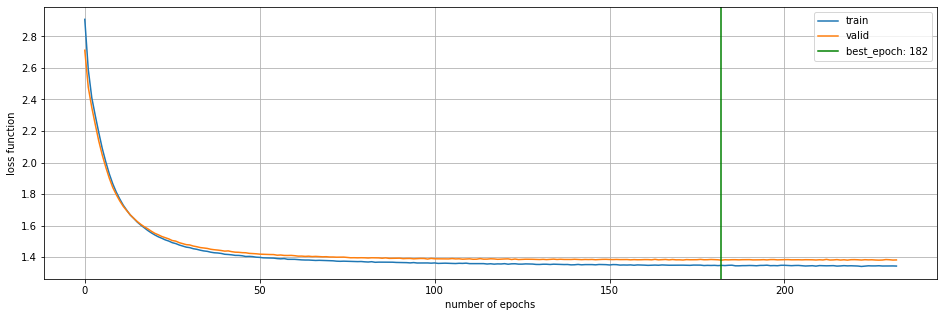

In [23]:
plot_losses(train_loss_history, valid_loss_history, best_valid_score, burn_in=0)

In [24]:
for features, targets in test_loader:
    pi, sigma = kernel_density_model(features)

mu = torch.from_numpy(cluster_centers).unsqueeze(dim=0)
mu = torch.cat(pi.shape[0]*[mu])

print(pi.shape, sigma.shape, mu.shape)

torch.Size([2500, 50]) torch.Size([2500, 50, 1]) torch.Size([2500, 50, 1])


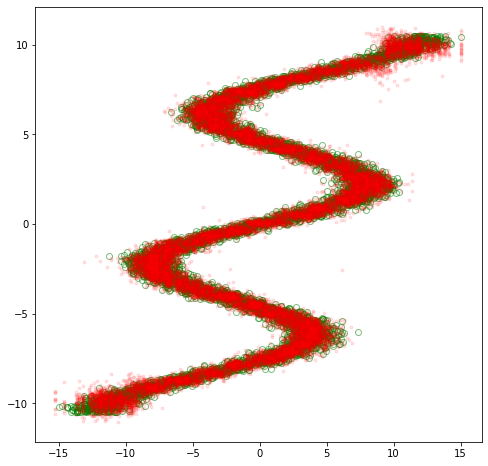

In [25]:
preds = sample_preds(
    torch.squeeze(pi), 
    torch.squeeze(sigma), 
    torch.squeeze(mu), 
    samples=10,
)

fig = plt.figure(figsize=(8,8))
plt.plot(X_train, y_train, 'go', alpha=0.5, markerfacecolor='none')
for i in range(preds.shape[1]):
    plt.plot(X_test, preds.data.numpy()[:, i].reshape(-1, 1), 'r.', alpha=0.1)
plt.show()

there are clear whole with 30 num_of_gaussians, so lets increase it

In [26]:
%%javascript
IPython.notebook.save_notebook()
IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [27]:
!jupyter nbconvert --to html $nb_name

[NbConvertApp] Converting notebook 05_mixture_kernel_density_model.ipynb to html
[NbConvertApp] Writing 1303111 bytes to 05_mixture_kernel_density_model.html
